# Data exploration

Let's first download the squad dataset and the trained model

In [1]:
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

--2021-04-24 08:10:26--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad/train-v2.0.json’

squad/train-v2.0.js 100%[===================>]  40.17M  85.5MB/s    in 0.5s    

2021-04-24 08:10:28 (85.5 MB/s) - ‘squad/train-v2.0.json’ saved [42123633/42123633]

--2021-04-24 08:10:28--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘squad/dev-v2.0.json’

sq

In [4]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GZQnz1ON9ET7Op-OipDnb2_RGam6WEwJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GZQnz1ON9ET7Op-OipDnb2_RGam6WEwJ" -O models && rm -rf /tmp/cookies.txt

--2021-04-24 08:11:08--  https://docs.google.com/uc?export=download&confirm=jugd&id=1GZQnz1ON9ET7Op-OipDnb2_RGam6WEwJ
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.139, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-8o-docs.googleusercontent.com/docs/securesc/e136iorsd9lq4iqn8so2ct1k7mhrpgi7/16cehbhqpc32afheoimv1eur9br1c5g4/1619251800000/16774955666988893746/07904973850869210983Z/1GZQnz1ON9ET7Op-OipDnb2_RGam6WEwJ?e=download [following]
--2021-04-24 08:11:08--  https://doc-0c-8o-docs.googleusercontent.com/docs/securesc/e136iorsd9lq4iqn8so2ct1k7mhrpgi7/16cehbhqpc32afheoimv1eur9br1c5g4/1619251800000/16774955666988893746/07904973850869210983Z/1GZQnz1ON9ET7Op-OipDnb2_RGam6WEwJ?e=download
Resolving doc-0c-8o-docs.googleusercontent.com (doc-0c-8o-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting

In [5]:
!unzip models

Archive:  models
  inflating: linear_model_all_CQ.pt  
  inflating: linear_model_onlyans_CQ.pt  
  inflating: linear_model_all_QC.pt  
  inflating: linear_model_noans.pt   
  inflating: linear_onlyans_QC.pt    


Now to read the squad files:

In [6]:
import json
from pathlib import Path
import numpy as np

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    qid = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                id = qa['id']
# Below line are for taking into account questions with no answers
                if not qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append({'text': '', 'answer_start':-1})
                    qid.append(id)
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
                    qid.append(id)

    return contexts, questions, answers, qid

train_contexts, train_questions, train_answers, train_id = read_squad('squad/train-v2.0.json')
val_contexts, val_questions, val_answers, val_id = read_squad('squad/dev-v2.0.json')

In [ ]:
len(train_contexts)

130319

Now we may take a look at our dataset

In [ ]:
print('context:',train_contexts[0],'\n question:', train_questions[0], '\n answer:', train_answers[0])

context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy". 
 question: When did Beyonce start becoming popular? 
 answer: {'text': 'in the late 1990s', 'answer_start': 269}


A first observation is the absence of any variable indicating the end of the answer. We will have to add it ourself

In [7]:
def add_end_idx(answers, contexts, questions):
    for answer, context, question in zip(answers, contexts,questions):
        gold_text = answer['text']
        start_idx = answer['answer_start'] 
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx 
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1 
            answer['answer_end'] = end_idx - 1    # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2 
            answer['answer_end'] = end_idx - 2   # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts, train_questions)
add_end_idx(val_answers, val_contexts, val_questions)

#Bert

To obtain our embeddings, we will use Bert model (further information can be found there: https://arxiv.org/abs/1810.04805 )

In [8]:
!pip install transformers

     |████████████████████████████████| 2.1MB 7.8MB/s 
     |████████████████████████████████| 901kB 35.2MB/s 
     |████████████████████████████████| 3.3MB 40.0MB/s 


We will use a 'Fast' tokenizer. As it can be guessed given the name, it allows a faster implementation of batch tokenization. \\
However what is particularly interesting for us is that it adds additionnal methods to map between the string and the token spaces which we will use to get the index of the answer tokens

In [9]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

#As we train the model, we need all inputs to be of the same size, that is why we set truncation and padding to True
#We concacenate questions and context as a single string before encoding

It is important to note that we trained models with different input formats. For each model we have a version with the format **[CLS] Question [SEP] Context [SEP]** and another version with **[CLS] Context [SEP] Question [SEP]**

In [ ]:
#train_encodings1 = tokenizer(train_questions, train_contexts, truncation=True, padding=True) 
#train_encodings2 = tokenizer( train_contexts, train_questions, truncation=True, padding=True)

In [10]:
val_encodings1 = tokenizer(val_questions, val_contexts, truncation=True, padding=True)
val_encodings2 = tokenizer( val_contexts, val_questions, truncation=True, padding=True)

By default, bert-base model support a length of 512 tokens. For many tasks, it is often way more than necessary. We could lose a lot of time / memory if we do not have a use for tha many tokens.

In [ ]:
maxi = []
for k in range(10000):
  l = 0
  t = train_encodings1.tokens(k)
  while l <511 and t[l+1] != '[PAD]':
    l+=1
  maxi.append(l)

(array([ 244.,  538.,  780., 1019., 1089.,  930.,  905.,  786.,  658.,
         580.,  538.,  352.,  286.,  310.,  275.,  148.,  149.,   71.,
          80.,   59.,   38.,   37.,   28.,   10.,   22.,   41.,    9.,
           2.,    3.,   13.]),
 array([ 38.        ,  53.76666667,  69.53333333,  85.3       ,
        101.06666667, 116.83333333, 132.6       , 148.36666667,
        164.13333333, 179.9       , 195.66666667, 211.43333333,
        227.2       , 242.96666667, 258.73333333, 274.5       ,
        290.26666667, 306.03333333, 321.8       , 337.56666667,
        353.33333333, 369.1       , 384.86666667, 400.63333333,
        416.4       , 432.16666667, 447.93333333, 463.7       ,
        479.46666667, 495.23333333, 511.        ]),
 <a list of 30 Patch objects>)

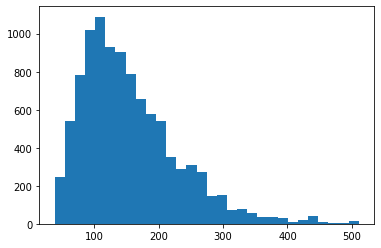

In [ ]:
import matplotlib.pyplot as plt
plt.hist(max, bins = 30 )

Most of the questions/context pairs token have a length inferior to 300. We will still keep the maximum length at 512 to see how our model perform on long questions. \\
The next step is to transform the character index to token index

In [11]:
def add_token_positions(encodings, answers, seq_indx):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        if answers[i]['answer_start'] == -1:
          start_positions.append(0)
          end_positions.append(0)
        else:
          start_positions.append(encodings.char_to_token(i, answers[i]['answer_start'],sequence_index = seq_indx))
          end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1, sequence_index = seq_indx))

        # if start position or end position is None, question is
        # out of bounds, we want our model to predict the '[CLS]' token 0 in that case
        if start_positions[-1] is None:
            start_positions[-1] = 0
        if end_positions[-1] is None:
            end_positions[-1] = 0


    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

#add_token_positions(train_encodings1, train_answers, 1)
#add_token_positions(train_encodings2, train_answers, 0)
add_token_positions(val_encodings1, val_answers, 1)
add_token_positions(val_encodings2, val_answers, 0)

We can now create our dataset inheriting the torch Dataset class.

In [12]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

#train_dataset1 = SquadDataset(train_encodings1)
#train_dataset2 = SquadDataset(train_encodings2)
val_dataset1 = SquadDataset(val_encodings1)
val_dataset2 = SquadDataset(val_encodings2)

In [ ]:
train_dataset.__getitem__(0)

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

The attention mask indicate which indexs are revelant and should be taken into account in the model (against the pad tokens added to have the same value).\\
Now we will use BERT to transform the input ids into embeddings

In [13]:
from transformers import DistilBertModel

model = DistilBertModel.from_pretrained('distilbert-base-uncased',
                                  output_hidden_states = False, # Whether the model returns all hidden-states.
                                  )

# Linear model

In [14]:
from torch import nn
class TokenClassifier(nn.Module):

    def __init__(self, D_in):
        super(TokenClassifier, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = model
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(D_in,2) # Linear classifier for start and end token
        
    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..

        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head

        pool = cont_reps.last_hidden_state
        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(pool)

        #Computing the loss:


        return logits

#Training the model

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm.notebook import tqdm
import torch.nn.functional as F

loss_fn = F.cross_entropy

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
classifier_model = TokenClassifier(768)
classifier_model.to(device)
classifier_model.train()

batch_multiplier = 1 #To multiply the batch size without increasing the memory consumption

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    count = 0
    time = 0
    for batch in tqdm(train_loader):
        
        if count == 0:
            optim.step()
            optim.zero_grad()
            count = batch_multiplier

        count -= 1
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions']
        end_positions = batch['end_positions']

        outputs = classifier_model(input_ids, attn_masks=attention_mask)
        target = torch.stack((start_positions,end_positions), 1).to(device)

        loss = loss_fn(outputs.to(device), target, ignore_index = 512) / batch_multiplier
        if time%50 == 0:
          print('epoch {}, batch {}, loss = {}'.format(epoch,time,loss))
        time+=1
        loss.backward()
        

classifier_model.eval()

epoch 0, batch 0, loss = 6.292059421539307
epoch 0, batch 50, loss = 3.6367571353912354
epoch 0, batch 100, loss = 2.616694688796997
epoch 0, batch 150, loss = 2.176823616027832
epoch 0, batch 200, loss = 1.9681984186172485
epoch 0, batch 250, loss = 1.6927497386932373
epoch 0, batch 300, loss = 2.132338047027588
epoch 0, batch 350, loss = 2.0629723072052
epoch 0, batch 400, loss = 1.541053056716919
epoch 0, batch 450, loss = 1.1894726753234863
epoch 0, batch 500, loss = 1.7015098333358765
epoch 0, batch 550, loss = 1.4064306020736694
epoch 0, batch 600, loss = 1.2769838571548462
epoch 0, batch 650, loss = 1.736924171447754
epoch 0, batch 700, loss = 1.5654034614562988
epoch 0, batch 750, loss = 1.613938331604004
epoch 0, batch 800, loss = 0.8647754788398743
epoch 0, batch 850, loss = 1.6228487491607666
epoch 0, batch 900, loss = 1.2136660814285278
epoch 0, batch 950, loss = 1.489058017730713
epoch 0, batch 1000, loss = 1.3615012168884277
epoch 0, batch 1050, loss = 1.414758563041687
e

epoch 1, batch 0, loss = 0.9520074129104614
epoch 1, batch 50, loss = 0.6884294152259827
epoch 1, batch 100, loss = 0.9208292961120605
epoch 1, batch 150, loss = 1.2402091026306152
epoch 1, batch 200, loss = 0.9515277743339539
epoch 1, batch 250, loss = 1.1169242858886719
epoch 1, batch 300, loss = 1.164657473564148
epoch 1, batch 350, loss = 0.5619871020317078
epoch 1, batch 400, loss = 0.6598108410835266
epoch 1, batch 450, loss = 0.535141110420227
epoch 1, batch 500, loss = 0.6957288980484009
epoch 1, batch 550, loss = 1.0445150136947632
epoch 1, batch 600, loss = 0.9628463983535767
epoch 1, batch 650, loss = 0.6713753938674927
epoch 1, batch 700, loss = 0.8427850604057312
epoch 1, batch 750, loss = 1.579906940460205
epoch 1, batch 800, loss = 0.9111588001251221
epoch 1, batch 850, loss = 0.8569850921630859
epoch 1, batch 900, loss = 0.7223135828971863
epoch 1, batch 950, loss = 1.1171908378601074
epoch 1, batch 1000, loss = 0.6432662010192871
epoch 1, batch 1050, loss = 0.821659922

epoch 2, batch 0, loss = 0.5867685675621033
epoch 2, batch 50, loss = 0.582286536693573
epoch 2, batch 100, loss = 0.7672915458679199
epoch 2, batch 150, loss = 0.48150238394737244
epoch 2, batch 200, loss = 0.6099282503128052
epoch 2, batch 250, loss = 0.6762793064117432
epoch 2, batch 300, loss = 0.5291643142700195
epoch 2, batch 350, loss = 0.9056618809700012
epoch 2, batch 400, loss = 0.6972644329071045
epoch 2, batch 450, loss = 0.5693967938423157
epoch 2, batch 500, loss = 0.4185504913330078
epoch 2, batch 550, loss = 0.6714328527450562
epoch 2, batch 600, loss = 0.5831555128097534
epoch 2, batch 650, loss = 0.567243218421936
epoch 2, batch 700, loss = 0.6767200827598572
epoch 2, batch 750, loss = 0.8143634796142578
epoch 2, batch 800, loss = 0.8680364489555359
epoch 2, batch 850, loss = 0.6475475430488586
epoch 2, batch 900, loss = 0.6791070103645325
epoch 2, batch 950, loss = 0.7834709882736206
epoch 2, batch 1000, loss = 0.45176607370376587
epoch 2, batch 1050, loss = 0.848931

TokenClassifier(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

In [ ]:
#torch.save(classifier_model, 'linear_model_ans.pt')

#Test model

## Loading the model

We can now delete the train dataset / encodings as they take up a lot of RAM

In [ ]:
#del train_dataset
#del train_encodings

We now load our 4 models

In [15]:
lin_model_all_CQ = torch.load('linear_model_all_CQ.pt')
lin_model_all_QC = torch.load('linear_model_all_QC.pt')
lin_model_onlyans_CQ = torch.load('linear_model_onlyans_CQ.pt')
lin_model_onlyans_QC = torch.load('linear_onlyans_QC.pt')

#The second parameter indicates whether or not the context precedes the question in the input
#The third parameter indicates whether or not the model was trained on only answerable questions
models = [(lin_model_all_CQ,1,0),
(lin_model_all_QC,0,0),
(lin_model_onlyans_CQ,1,1),
(lin_model_onlyans_QC,0,1)]

Once again we will use the gpu to accelerate the model computations

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for model in models:
  model[0].to(device)
  model[0].eval()

## Prediction function for scoring

In [17]:
from tqdm.notebook import tqdm

def create_prediction_dict_for_scores(model,encodings, answers,questions, dataset, id, context):




  predicted_answer = []
  real_answer = []
  ans_confidence = []
  noans_confidence = []

  for k in tqdm(range(len(dataset))):
    #We get each sample from the validation dataset
    sample = dataset.__getitem__(k)
    #We run the input_ids and attention_mask through the model
    input_ids = sample['input_ids'].to(device)
    attention_mask = sample['attention_mask'].to(device)
    outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
    #We separate the predicted start and end
    out1,out2 = torch.chunk(torch.softmax(outputs.float(),dim = -2), chunks = 2 , dim = 2)
    predicted_1 = torch.argmax(out1, dim = 1).item()

    predicted_2 = (predicted_1 + torch.argmax(out2.squeeze()[predicted_1:])).item()


    ans_confidence.append(out1.squeeze()[predicted_1].item() + out2.squeeze()[predicted_2].item() )
    noans_confidence.append(out1.squeeze()[0].item() + out2.squeeze()[0].item() )
  
    #Trying to simply un-tokenize the answers token may make us lose information. That is why we'll use the token_to_char index mapping'
    if predicted_1 == 0:
      predicted_answer.append('')
    else:
      context_start = encodings.token_to_chars(k,predicted_1)[0]
      context_end = encodings.token_to_chars(k,predicted_2)[1]
      predicted_answer.append(context[k][context_start:context_end])
    if sample['start_positions'] == 0:
      real_answer.append('')
    else:
      real_st = encodings.token_to_chars(k,sample['start_positions'].item())[0]
      real_e = encodings.token_to_chars(k,sample['end_positions'].item())[1]
      real_answer.append(context[k][real_st:real_e])



  data_dict = {"qid":id, "question":questions, 'ans_conf': ans_confidence, 'no_ans_conf': noans_confidence,
             'predicted_answer':predicted_answer, 'real_answer':real_answer,
              'original_answer': [k['text'] for k in answers] }

  return data_dict

In [142]:
val_encodings = [val_encodings1,val_encodings2]
val_dataset = [val_dataset1,val_dataset2]

In [143]:
dic_list = [
            create_prediction_dict_for_scores(model[0],val_encodings[model[1]],
                                              val_answers,val_questions, val_dataset[model[1]], val_id, val_contexts )
            for model in models
]

In [146]:
import pandas as pd
dic_df = [pd.DataFrame(dic) for dic in dic_list]
dic_df[3].head(10)

,qid,question,ans_conf,no_ans_conf,predicted_answer,real_answer,original_answer
0,56ddde6b9a695914005b9628,In what country is Normandy located?,1.979519,1.510338e-06,France,France,France
1,56ddde6b9a695914005b9628,In what country is Normandy located?,1.979519,1.510338e-06,France,France,France
2,56ddde6b9a695914005b9628,In what country is Normandy located?,1.979519,1.510338e-06,France,France,France
3,56ddde6b9a695914005b9628,In what country is Normandy located?,1.979519,1.510338e-06,France,France,France
4,56ddde6b9a695914005b9629,When were the Normans in Normandy?,1.775445,4.605879e-07,10th and 11th centuries,10th and 11th centuries,10th and 11th centuries
5,56ddde6b9a695914005b9629,When were the Normans in Normandy?,1.775445,4.605879e-07,10th and 11th centuries,in the 10th and 11th centuries,in the 10th and 11th centuries
6,56ddde6b9a695914005b9629,When were the Normans in Normandy?,1.775445,4.605879e-07,10th and 11th centuries,10th and 11th centuries,10th and 11th centuries
7,56ddde6b9a695914005b9629,When were the Normans in Normandy?,1.775445,4.605879e-07,10th and 11th centuries,10th and 11th centuries,10th and 11th centuries
8,56ddde6b9a695914005b962a,From which countries did the Norse originate?,1.963104,1.180180e-07,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway"
9,56ddde6b9a695914005b962a,From which countries did the Norse originate?,1.963104,1.180180e-07,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway"


#Evaluation

## Pipeline for single prediction

In [18]:
def single_prediction(question,context, lin_model, tau = 1, cq = 0):
  if cq: #Encoding first context then question
    encoding = tokenizer(context, question, truncation=True, padding=True)
  else:
    encoding = tokenizer(question, context, truncation=True, padding=True)
  outputs = lin_model(torch.tensor(encoding['input_ids']).unsqueeze(0).to(device),
                      attn_masks=torch.tensor(encoding['attention_mask']).unsqueeze(0).to(device))
  out1,out2 = torch.chunk(torch.softmax(outputs.float(),dim = -2), chunks = 2 , dim = 2)
  predicted_1 = torch.argmax(out1, dim = 1).item()
  predicted_2 = predicted_1 + torch.argmax(out2.squeeze()[predicted_1:]).item()
  predicted_1 = torch.argmax(out1, dim = 1).item()
  predicted_2 = (predicted_1 + torch.argmax(out2.squeeze()[predicted_1:])).item()
  
  ans_confidence = out1.squeeze()[predicted_1].item() + out2.squeeze()[predicted_2].item() 
  noans_confidence =out1.squeeze()[0].item() + out2.squeeze()[0].item() 
  if ans_confidence > tau + noans_confidence:
    predicted_answer = tokenizer.convert_tokens_to_string(encoding.tokens()[predicted_1:predicted_2+1])
  else:
    predicted_answer = ''
  return predicted_answer, ans_confidence                                                      

## Evaluation functions

In [19]:
import collections
import json
import numpy as np
import os
import re
import string
import sys


#Squad scores are evaluated by comparing normalized answers

def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

def get_raw_scores(dataset, answer = "original_answer", onlyansq = False, min_len = 0):
  ''' Return two dictionnary with the qid as key and the f1/em score as content. Onlyansq indicate whether or not the model should take
  into account only anwserable questions. min_len indicates the minimum length the context must have for the question to be taken into
  account. '''
  exact_scores = {}
  f1_scores = {}
  qid = dataset['qid'][0]
  em = 0
  f1 = 0
  for k in tqdm(range(len(dataset))):
    #we don't take into account question that don't have answers or context too short
    if onlyansq and dataset[answer][k] == '' and len(val_contexts[k]) >= min_len: 
      pass
    elif qid != dataset['qid'][k]: #If we have a new question, we store the scores of the previous one
      exact_scores[qid] = em
      f1_scores[qid] = f1
      qid = dataset['qid'][k]

      em = compute_exact(dataset[answer][k],dataset['predicted_answer'][k])
      f1 = compute_f1(dataset[answer][k],dataset['predicted_answer'][k])
    
    else: #Else we take the maximum score among the different answers to this question
      em = np.max([em,compute_exact(dataset[answer][k],dataset['predicted_answer'][k])])
      f1 = np.max([f1,compute_f1(dataset[answer][k],dataset['predicted_answer'][k])])

  return exact_scores, f1_scores



def make_eval_dict(exact_scores, f1_scores, qid_list=None):
  ''' Average over the raw scores'''
  if not qid_list:
    total = len(exact_scores)
    return collections.OrderedDict([
        ('exact', 100.0 * sum(exact_scores.values()) / total),
        ('f1', 100.0 * sum(f1_scores.values()) / total),
        ('total', total),
    ])
  else:
    total = len(qid_list)
    return collections.OrderedDict([
        ('exact', 100.0 * sum(exact_scores[k] for k in qid_list) / total),
        ('f1', 100.0 * sum(f1_scores[k] for k in qid_list) / total),
        ('total', total),
    ])



def get_raw_scores_sep(dataset, min_len = 0):
  '''Same as get_raw_scores but calculate separately the score for answerable and unanswerable questions '''
  exact_scores_ans = {}
  f1_tot = {}
  exact_tot = {}
  f1_scores_ans = {}
  exact_scores_noans = {}
  f1_scores_noans = {}
  qid = dataset['qid'][0]
  em = 0
  f1 = 0
  for k in tqdm(range(len(dataset))):
    #We only take into account context above a certain lengths. Used later in the qualitative analysis
    if len(val_contexts[k]) < min_len:
      pass
    elif qid != dataset['qid'][k]: #If we have a new question, we store the scores of the previous one
      if dataset['original_answer'][k-1] != '':
        exact_scores_ans[qid] = em
        f1_scores_ans[qid] = f1

      else:
        exact_scores_noans[qid] = em
        f1_scores_noans[qid] = f1

      exact_tot[qid] = em
      f1_tot[qid] = f1
      qid = dataset['qid'][k]

      em = compute_exact(dataset['original_answer'][k],dataset['predicted_answer'][k])
      f1 = compute_f1(dataset['original_answer'][k],dataset['predicted_answer'][k])
    
    else: #Else we take the maximum score among the different answers to this question
      em = np.max([em,compute_exact(dataset['original_answer'][k],dataset['predicted_answer'][k])])
      f1 = np.max([f1,compute_f1(dataset['original_answer'][k],dataset['predicted_answer'][k])])

  return exact_scores_ans, f1_scores_ans, exact_scores_noans, f1_scores_noans, exact_tot, f1_tot

def get_raw_scores_sep_nan_tresh(dataset,t):
  ''' Same as get_raw_scores_sep but with a threshold as described in the article '''
  f1_tot = {}
  exact_tot = {}  
  exact_scores_ans = {}
  f1_scores_ans = {}
  exact_scores_noans = {}
  f1_scores_noans = {}
  qid = dataset['qid'][0]
  em = 0
  f1 = 0
  for k in (range(len(dataset))):
    if qid != dataset['qid'][k]: #If we have a new question, we store the scores of the previous one
      if dataset['original_answer'][k-1] != '':
        exact_scores_ans[qid] = em
        f1_scores_ans[qid] = f1
      else:
        exact_scores_noans[qid] = em
        f1_scores_noans[qid] = f1
      
      exact_tot[qid] = em
      f1_tot[qid] = f1
      qid = dataset['qid'][k]

      if dataset['ans_conf'][k] > t + dataset['no_ans_conf'][k]:
        em = compute_exact(dataset['original_answer'][k],dataset['predicted_answer'][k])
        f1 = compute_f1(dataset['original_answer'][k],dataset['predicted_answer'][k])
      else:
        em = compute_exact(dataset['original_answer'][k],'')
        f1 = compute_f1(dataset['original_answer'][k],'')        
    
    else: #Else we take the maximum score among the different answers to this question
      if dataset['ans_conf'][k] > t + dataset['no_ans_conf'][k]:
        em = max(em,compute_exact(dataset['original_answer'][k],dataset['predicted_answer'][k]))
        f1 = max(f1,compute_f1(dataset['original_answer'][k],dataset['predicted_answer'][k]))
      else:
        em = max(em,compute_exact(dataset['original_answer'][k],''))
        f1 = max(f1,compute_f1(dataset['original_answer'][k],''))        

  return exact_scores_ans, f1_scores_ans, exact_scores_noans, f1_scores_noans, exact_tot, f1_tot


## Comparing 2 types of answers

In [ ]:
re_tokenized_norm_ans = np.array([normalize_answer(s) for s in df['original_answer']]) #untokenized answers

In [ ]:
real_norm_ans = np.array([normalize_answer(s) for s in df['real_answer']])

In [ ]:
c = 0
for k in range(len(re_tokenized_norm_ans)):
  if re_tokenized_norm_ans[k] != real_norm_ans[k]:
    print('question', k, ' \n real ans:', real_norm_ans[k], '\n re tokenized ans:', re_tokenized_norm_ans[k])
    c+=1
  if c == 10:
    break

question 1238  
 real ans: richest 
 re tokenized ans: rich
question 1869  
 real ans: victoria constitution act 1855 
 re tokenized ans: victoria constitution act 185
question 1980  
 real ans: gold rushes 
 re tokenized ans: gold rush
question 1981  
 real ans: gold rushes 
 re tokenized ans: gold rush
question 2114  
 real ans: 1562 to 1598 
 re tokenized ans: 562 to 1598
question 2280  
 real ans: australians 
 re tokenized ans: australia
question 2281  
 real ans: australians 
 re tokenized ans: australia
question 4828  
 real ans: israelis 
 re tokenized ans: israel
question 5013  
 real ans: japanese 
 re tokenized ans: japan
question 5022  
 real ans: japanese 
 re tokenized ans: japan


A few answers are different but statistically it is not relevant

## F1 and EM scores

In [147]:
f1_onlyansq = []
em_onlyansq = []
f1_all= []
em_all = []
f1_noans = []
em_noans = []
total = [0,0,0]
for df in dic_df:
  em, f1, em_no, f1_no, em_tot, f1_tot = get_raw_scores_sep(df)
  
  scores = make_eval_dict(em, f1)
  f1_onlyansq.append(scores['f1'])
  em_onlyansq.append(scores['exact'])
  total[0] = scores['total']

  scores = make_eval_dict(em_no, f1_no)
  f1_noans.append(scores['f1'])
  em_noans.append(scores['exact'])
  total[1] = scores['total']

  scores = make_eval_dict(em_tot, f1_tot)
  f1_all.append(scores['f1'])
  em_all.append(scores['exact'])
  total[2] = scores['total']


score_df = pd.DataFrame({"f1 on answerable questions": f1_onlyansq, "f1 on unanswerable questions": f1_noans, "total f1": f1_all,
                         "EM on answerable questions": em_onlyansq, "EM on unanswerable questions": em_noans, "total EM": em_all
                         })

In [148]:
score_df

,f1 on answerable questions,f1 on unanswerable questions,total f1,EM on answerable questions,EM on unanswerable questions,total EM
0,74.136498,61.322342,67.720785,66.447368,61.322342,63.881402
1,70.293987,65.259085,67.773143,63.782051,65.259085,64.521563
2,83.366317,0.016824,41.635405,74.224022,0.016824,37.070418
3,83.988199,0.016824,41.945927,74.848178,0.016824,37.382075


## Threshold choice

We will now compute the scores we get by adding hard thresholding on the answer confidence.

In [ ]:
r = np.linspace(0,2,100)
f_1_hasans = []
f_1_noans = []
exact_hasans = []
exact_noans = []
exact_score = []
f1_score = []
for k in tqdm(r):
  em, f1, em_bis, f1_bis, em_t, f1_t = get_raw_scores_sep_nan_tresh(dic_df[0],k)
  a,b = make_eval_dict(em, f1), make_eval_dict(em_bis, f1_bis)

  c = make_eval_dict(em_t,f1_t)
  f_1_hasans.append(a['f1'])
  f_1_noans.append(b['f1'])
  exact_hasans.append(a['exact'])
  exact_noans.append(b['exact'])
  exact_score.append(c['exact'])
  f1_score.append(c['f1'])

In [ ]:
f_1_hasans2 = []
f_1_noans2 = []
exact_hasans2 = []
exact_noans2 = []
exact_score2 = []
f1_score2 = []
for k in tqdm(r):
  em, f1, em_bis, f1_bis, em_t, f1_t = get_raw_scores_sep_nan_tresh(dic_df[1],k)
  a,b = make_eval_dict(em, f1), make_eval_dict(em_bis, f1_bis)

  c = make_eval_dict(em_t,f1_t)
  f_1_hasans2.append(a['f1'])
  f_1_noans2.append(b['f1'])
  exact_hasans2.append(a['exact'])
  exact_noans2.append(b['exact'])
  exact_score2.append(c['exact'])
  f1_score2.append(c['f1'])

In [ ]:
f_1_hasans3 = []
f_1_noans3 = []
exact_hasans3 = []
exact_noans3 = []
exact_score3 = []
f1_score3 = []
for k in tqdm(r):
  em, f1, em_bis, f1_bis, em_t, f1_t = get_raw_scores_sep_nan_tresh(dic_df[2],k)
  a,b = make_eval_dict(em, f1), make_eval_dict(em_bis, f1_bis)

  c = make_eval_dict(em_t,f1_t)
  f_1_hasans3.append(a['f1'])
  f_1_noans3.append(b['f1'])
  exact_hasans3.append(a['exact'])
  exact_noans3.append(b['exact'])
  exact_score3.append(c['exact'])
  f1_score3.append(c['f1'])

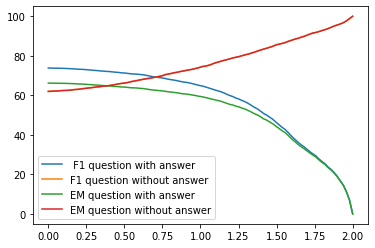

In [ ]:
import matplotlib.pyplot as plt

plt.plot(r,f_1_hasans, label = " F1 question with answer")
plt.plot(r,f_1_noans, label = "F1 question without answer")
plt.plot(r,exact_hasans, label = "EM question with answer")
plt.plot(r,exact_noans, label = "EM question without answer")
plt.legend()
plt.show()

As expected, the score on unanswerable question rise while it diminishes on other questions

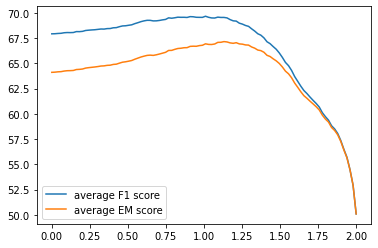

In [ ]:
plt.plot(r,f1_score, label = "average F1 score")
plt.plot(r,exact_score, label = "average EM score")
plt.legend()
plt.show()

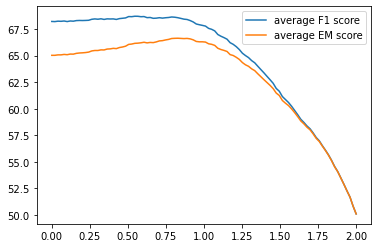

In [ ]:
plt.plot(r,f1_score2, label = "average F1 score")
plt.plot(r,exact_score2, label = "average EM score")
plt.legend()
plt.show()

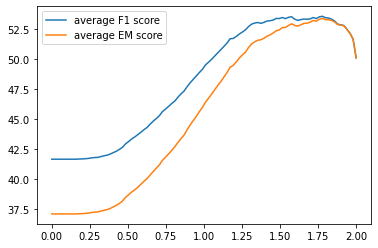

In [ ]:
plt.plot(r,f1_score3, label = "average F1 score")
plt.plot(r,exact_score3, label = "average EM score")
plt.legend()
plt.show()

This last plot is particularly interesting as it could make quite a lot of sense to use the model who wasn't trained to detect unanswerable question and decide that if the model is not confident enough in its prediction, the question has no answer. Doing so allow the scores to jump to above 50, which is still not comparable to the model trained to detect unanswerable questions.

In [149]:
f1_onlyansq = []
em_onlyansq = []
f1_all= []
em_all = []
f1_noans = []
em_noans = []
total = [0,0,0]
for df in dic_df:
  em, f1, em_no, f1_no, em_tot, f1_tot = get_raw_scores_sep_nan_tresh(df, 0.8)
  
  scores = make_eval_dict(em, f1)
  f1_onlyansq.append(scores['f1'])
  em_onlyansq.append(scores['exact'])
  total[0] = scores['total']

  scores = make_eval_dict(em_no, f1_no)
  f1_noans.append(scores['f1'])
  em_noans.append(scores['exact'])
  total[1] = scores['total']

  scores = make_eval_dict(em_tot, f1_tot)
  f1_all.append(scores['f1'])
  em_all.append(scores['exact'])
  total[2] = scores['total']


score_df_tresh = pd.DataFrame({"f1 on answerable questions": f1_onlyansq, "f1 on unanswerable questions": f1_noans, "total f1": f1_all,
                         "EM on answerable questions": em_onlyansq, "EM on unanswerable questions": em_noans, "total EM": em_all
                         })

With a thresholding of 0.8 we obtain the following scores

In [150]:
score_df_tresh

,f1 on answerable questions,f1 on unanswerable questions,total f1,EM on answerable questions,EM on unanswerable questions,total EM
0,68.036684,70.928668,69.484625,61.707152,70.928668,66.324124
1,58.181577,79.155451,68.682647,54.183536,79.155451,66.686321
2,80.031695,12.886945,46.414074,72.267206,12.886945,42.537062
3,80.978140,10.380215,45.631605,73.228745,10.380215,41.762129


## Qualitative Analysis

Let's rank the questions where our models make erros according to the confidence they have in their answer.

In [ ]:
def errors(data):
  em, f1 = get_raw_scores(data)
  df = data.loc[data['qid'].map(em) == 0]
  df = df.sort_values(by='ans_conf', ascending=True)
  df = df.drop_duplicates(subset = ['qid'], keep = 'first')
  return df

In [ ]:
dat = errors(dic_df[1])

In [ ]:
dat.head(10)

,qid,question,ans_conf,no_ans_conf,predicted_answer,real_answer,original_answer
16601,57286f373acd2414000df9dc,What did the Mongol elites wish Buyantu didn't...,0.170371,0.082110,discontent,actively support and adopt mainstream Chinese ...,actively support and adopt mainstream Chinese ...
13357,5a67a1e3f038b7001ab0c38b,What are boarding schools that teach English c...,0.175479,0.001199,Nepali and/or the state's official language,,
16321,5ad3ffb3604f3c001a3ffc93,What is the Japanese name for the Yuan dynasty?,0.181698,0.134367,"Kublai Khan, leader of the Mongolian Borjigin ...",,
4872,571a52cb4faf5e1900b8a969,______ In both liquid and gas form can fastly ...,0.215043,0.052531,Concentrated O\n2 will allow combustion to pro...,oxygen,oxygen
2923,5ad25e99d7d075001a428f2e,In what part of the now US was New France?,0.217083,0.156517,Bushwick,,
14650,5729da0faf94a219006aa679,While competition between workers drives down ...,0.255478,0.237307,Professional and labor organizations,employers,employers
16397,5ad40158604f3c001a3ffd0d,What Han Chinese leader rejected the Mongols?,0.259024,0.016982,"Liu Heima (劉黑馬, Liu Ni), and the Khitan Xiao Z...",,
4891,571ce9bddd7acb1400e4c1a1,Because of the danger inherent in concentrated...,0.259837,0.028874,ignition sources are minimized,special training to ensure that ignition sourc...,special training to ensure that ignition sourc...
16396,5ad40158604f3c001a3ffd0c,What Khitan leader rejected the Mongols?,0.260120,0.030029,Shi Tianxiang,,
14659,5727ee372ca10214002d99ed,Survivial is at the heart of what concept for ...,0.263809,0.190560,entrepreneurialism,Necessity-based entrepreneurship,Necessity-based entrepreneurship


### Trap question without answer

Among the questions where our models failed but still printed a high confidence scores, a lot of them are actually tricky questions which contains a trap like the question belows. The string "but failed" added at the end negates the previous sentence. Our models don't fare very well capturing this subtility.

In [ ]:
val_questions[263], val_contexts[263][226:340]

('Who carved out a state for himself from Moorish lands?',
 ' Roger de Tosny travelled to the Iberian Peninsula to carve out a state for himself from Moorish lands, but failed')

In [ ]:
question = val_questions[263]
context = val_contexts[263]
for model in models:
  print(single_prediction(question,context, model[0], cq =model[1]))

('roger de tosny', 1.9995988011360168)
('roger de tosny', 1.6906784176826477)
('roger de tosny', 1.99739009141922)
('roger de tosny', 1.9962456226348877)
('roger de tosny', 1.6055883169174194)


Another example below. Our models struggle to capture the difference between "wife" and "husband". It recognize their proximity so that is uses one instead of the other but can't differentiate them well enough.

In [ ]:
val_questions[17049],val_contexts[17049][402:553]

(" Who was Ogedei's husband?",
 "The publication of a Taoist text inscribed with the name of Töregene Khatun, Ögedei's wife, is one of the first printed works sponsored by the Mongols.")

In [ ]:
question = val_questions[17049]
context = val_contexts[17049]
for model in models:
  print(single_prediction(question,context, model[0], cq =model[1]))

('toregene khatun', 1.970371961593628)
('toregene khatun', 1.992118239402771)
('toregene khatun', 1.9949983954429626)
('toregene khatun', 1.9873049855232239)
('toregene khatun', 1.9858943819999695)


### Question with the answer indirectly mentionned

We also saw quite a few question where the answer was not a direct transformation of a part of the context. In that case "to the discontent of" has become "Wish Buyantu didn't do". Our models which only handle question with answers have managed to find a correct answer unlike the other models. They seems to perform a little better with this type of question

In [ ]:
val_questions[16601] , val_contexts[16601][78:231]

("What did the Mongol elites wish Buyantu didn't do?",
 'He was the first Yuan emperor to actively support and adopt mainstream Chinese culture after the reign of Kublai, to the discontent of some Mongol elite.')

In [ ]:
question = val_questions[16601]
context = val_contexts[16601]
for model in models:
  print(single_prediction(question,context, model[0], cq =model[1]))

('', 0.4369850158691406)
('', 0.23008444905281067)
('support and adopt mainstream chinese culture', 1.1928627789020538)
('actively support and adopt mainstream chinese culture', 1.603739857673645)
('', 0.5933842658996582)


### Normal question

In this example, the question is quite easy enough to answer. Our models trained to handle questions without answer can't find an answer to this one while the other models handle it just fine. An interesting thing to note is that replacing "secondary" by "second" gives us a good answer for every models.

In [ ]:
val_questions[6953]

'Which entity is the secondary legislative body?'

In [ ]:
val_contexts[6953][:111]

'The second main legislative body is the Council, which is composed of different ministers of the member states.'

In [ ]:
question = val_questions[6953]
context = val_contexts[6953]
for model in models:
  print(single_prediction(question,context, model[0], cq =model[1]))

('', 1.9642506837844849)
('', 1.9960386157035828)
('the council', 1.8274518251419067)
('the council', 1.6233164072036743)
('', 1.990738570690155)


In [ ]:
question = "which entity is the second legislative body ?"
context = val_contexts[6953]
for model in models:
  print(single_prediction(question,context, model[0], cq =model[1]))

('the council', 1.976470947265625)
('the council', 1.8888619542121887)
('the council', 1.8890212178230286)
('the council', 1.7377405166625977)
('the council', 1.4543826580047607)


### Bad questions

Sometime, the questions are simply badly formulated and the answers don't make that much sense:

In [ ]:
val_questions[4891]

'Because of the danger inherent in concentrated oxygen, what is a concern about keeping it?'

In [ ]:
val_contexts[4891]

'Concentrated O\n2 will allow combustion to proceed rapidly and energetically. Steel pipes and storage vessels used to store and transmit both gaseous and liquid oxygen will act as a fuel; and therefore the design and manufacture of O\n2 systems requires special training to ensure that ignition sources are minimized. The fire that killed the Apollo 1 crew in a launch pad test spread so rapidly because the capsule was pressurized with pure O\n2 but at slightly more than atmospheric pressure, instead of the 1⁄3 normal pressure that would be used in a mission.[k]'

In [ ]:
val_answers[4891]

{'answer_end': 314,
 'answer_start': 252,
 'text': 'special training to ensure that ignition sources are minimized'}

In [ ]:
question = val_questions[4891]
context = val_contexts[4891]
for model in models:
  print(single_prediction(question,context, model[0], cq =model[1]))

('ignition sources are minimized', 1.023759126663208)
('', 0.2607700452208519)
('ignition sources are minimized', 1.2969841659069061)
('', 0.6422334760427475)
('', 0.4497601389884949)


### Long questions

One of our interogations was how our model handle long paragraphs. We tested our models on the 20% longest contexts

In [ ]:
len([len(k) for k in val_contexts if len(k) > 1000]) / len(val_contexts)

0.20383281898883682

In [ ]:
f1_onlyansq = []
em_onlyansq = []
f1_all= []
em_all = []
f1_noans = []
em_noans = []
total = [0,0,0]
for df in dic_df:
  em, f1, em_no, f1_no, em_tot, f1_tot = get_raw_scores_sep(df, min_len = 1000)
  
  scores = make_eval_dict(em, f1)
  f1_onlyansq.append(scores['f1'])
  em_onlyansq.append(scores['exact'])
  total[0] = scores['total']

  scores = make_eval_dict(em_no, f1_no)
  f1_noans.append(scores['f1'])
  em_noans.append(scores['exact'])
  total[1] = scores['total']

  scores = make_eval_dict(em_tot, f1_tot)
  f1_all.append(scores['f1'])
  em_all.append(scores['exact'])
  total[2] = scores['total']


score_df_len = pd.DataFrame({"f1 on answerable questions": f1_onlyansq, "f1 on unanswerable questions": f1_noans, "total f1": f1_all,
                         "EM on answerable questions": em_onlyansq, "EM on unanswerable questions": em_noans, "total EM": em_all
                         })

In [ ]:
score_df_len

,f1 on answerable questions,f1 on unanswerable questions,total f1,EM on answerable questions,EM on unanswerable questions,total EM
0,73.366319,62.607204,68.099682,65.789474,62.607204,64.231738
1,69.613717,67.066895,68.367036,63.569079,67.066895,65.281276
2,82.134103,0.000000,41.929080,72.615132,0.000000,37.069689
3,82.684572,0.000000,42.210092,73.273026,0.000000,37.405542
4,73.380808,63.893654,68.736802,65.378289,63.893654,64.651553


We lose 0.5-1 points in every score. Which is not really statistically revelant. Thus we can't say that our model have problems handling longer contexts (as long as it is within the 512 tokens range)

# Wikipedia api



## Model

In [20]:
!pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp37-none-any.whl size=11686 sha256=04b6b915a12433f45c895118aa742beb5d2ba7ebf1baaf00572c310ab94e3dca
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


We can see an example of wikipedia API:

In [21]:
import wikipedia

sch = wikipedia.search("How many death did katrina cause ?", results = 5)
sch

['Hurricane Katrina',
 'Effects of Hurricane Katrina in New Orleans',
 'Death Race 3: Inferno',
 'Memorial Medical Center and Hurricane Katrina',
 'Death of Tina Fontaine']

In [23]:
from numpy.random import choice

def prediction_onlyq(question, model, cq, hard_t = 2,  n = 5, min_len = 300, tau = 0.8):
  sch = wikipedia.search(question, results = n)
  answers = []
  conf = []
  cont = []
  if sch == []:
    return [], [], []
  for k in range(len(sch)):
    try: #Some wikipedia pages are bugged and don't load. If this happens we skip them
      ktr = wikipedia.page(sch[k])
      a = ktr.content.split('\n')
      for context in a:
        ans, c = single_prediction(question,context, model, tau, cq)
        if ans != '' and c < hard_t and len(context) > min_len:
          answers.append(ans)
          conf.append(c)
          cont.append(context)
    except wikipedia.PageError:
      print('Error at page', k)
    except wikipedia.DisambiguationError as e: #If this error occurs we select a random page
      s = choice(e.options)
      ktr = wikipedia.page(s)    
      a = ktr.content.split('\n')
      for context in a:
        ans, c = single_prediction(question,context, model, tau, cq)
        if ans != '' and c < hard_t and len(context) > min_len:
          answers.append(ans)
          conf.append(c)
          cont.append(context)
  top_5_idx = np.flip(np.argsort(conf)[-5:])

  top_5_values = [answers[i] for i in top_5_idx]
  top_5_cont = [cont[i] for i in top_5_idx]
  top_5_conf = [conf[i] for i in top_5_idx]


  return top_5_values, top_5_conf, top_5_cont

## Test

In [24]:
question = "What does NLP stand for ?"

In [26]:
answers, conf, cont = prediction_onlyq(question, models[1][0], models[1][1], n =5)

Error at page 3
Error at page 4


In [27]:
answers

['natural - language programming',
 'neuro - linguistic programming',
 'natural language processing',
 'neuro - linguistic programming',
 'strategy']

In [28]:
answers, conf, cont = prediction_onlyq(question, models[2][0], models[2][1], n =5)
answers

Error at page 3
Error at page 4


['natural - language programming',
 'neuro - linguistic programming',
 'natural language processing',
 'resume parsers',
 'strategy']

## Evaluation

Unfortunately it is quite hard to obtain a proper metric evaluation as the wikipedia API is not optimized for this kind of tasks and the model takes simply too much time to run on any sample statisticaly big enough. By tinkering around the model we still found some interesting observation

### Questions with numerical query 

In [34]:
question = "How many people live in France ?"
answers, conf, cont = prediction_onlyq(question, models[1][0], models[1][1], n =5)

Error at page 4


In [35]:
answers

['67. 4 million',
 '800, 000',
 '3 million',
 'more than one quarter',
 '3. 5 million']

In [36]:
cont[0]

'The demography of France is monitored by the Institut national d\'études démographiques (INED) and the Institut national de la statistique et des études économiques (INSEE). As of 1 January 2021, 67.4 million people lived in France, including the 13 metropolitan regions (65,249,843), which is mainland France located in Europe and the 5 overseas regions (2,172,398), but excluding the overseas collectivities and territories (604,000).In March 2017, the population of France officially reached the 67,000,000 mark. It had reached 66,000,000 in early 2014. Between the years 2010–17, the population of France grew from 64,613,000 to 66,991,000 (i.e. about 2.4 million people in a span of 7 years), making France one of the fastest-growing countries in Europe. The population of France is growing by 1,000,000 people every three years- an average annual increase of 340,000 people, or +0.6%.France was historically Europe\'s most populous country. During the Middle Ages, more than one-quarter of Eur

In [39]:
answers, conf, cont = prediction_onlyq(question, models[2][0], models[2][1], n =5)

Error at page 4


In [40]:
answers

['800, 000', 'how many', '38 %', '65, 000', '5, 000']

In [41]:
cont[0]

'The following table shows immigrants and second-generation immigrants by origin as of 2008 according to a study published by Insee in 2012. Third-generation immigrants, illegal immigrants, as well as ethnic minorities like black people from the French overseas territories residing in metropolitan France (800,000), Roms (500,000) or people born in Maghreb with French citizenship at birth (1 million Maghrebi Jews, Harkis and Pied-Noir) and their descendants, who are French by birth and not considered as immigrants or immigrant descendants, are not taken into account.'

In [42]:
conf[0]

1.9146150350570679

Our first two models answer this kind of question better than the other 2 who display a very high confidence score

In [61]:
question = "How many people died in WW2 ?"
answers, conf, cont = prediction_onlyq(question, models[2][0], models[2][1], n =5)

Error at page 0


In [68]:
answers

['tens of millions',
 'tens of thousands',
 'tens or hundreds of thousands',
 '2020',
 'four']

In [66]:
cont[0]

"World War II or the Second World War, often abbreviated as WWII or WW2, was a global war that lasted from 1939 to 1945. It involved the vast majority of the world's countries—including all the great powers—forming two opposing military alliances: the Allies and the Axis powers. In a state of total war, directly involving more than 100 million personnel from more than 30 countries, the major participants threw their entire economic, industrial, and scientific capabilities behind the war effort, blurring the distinction between civilian and military resources. Aircraft played a major role in the conflict, including the strategic bombing of population centres, and, with the development of nuclear weapons, the only two uses of such in war. World War II was the deadliest conflict in human history, resulting in 70 to 85 million fatalities, with more civilians than military personnel killed. Tens of millions of people died due to genocides (including the Holocaust), starvation, massacres, an

We can see that the answer (70 to 85 million fatalities) is in one of the context provided. If we look deeper into why our model didn't select it

In [70]:
model = models[2]  
  
if models[1]: #Encoding first context then question
    encoding = tokenizer(cont[0], question, truncation=True, padding=True)
else:
    encoding = tokenizer(question, cont[0], truncation=True, padding=True)
outputs = model[0](torch.tensor(encoding['input_ids']).unsqueeze(0).to(device),
                      attn_masks=torch.tensor(encoding['attention_mask']).unsqueeze(0).to(device))
out1,out2 = torch.chunk(torch.softmax(outputs.float(),dim = -2), chunks = 2 , dim = 2)

In [81]:
torch.argsort(out1.squeeze(), descending = True)

tensor([172, 158, 160, 144, 174,  72,  70, 165, 176, 180,  13,  71, 161, 177,
         76,  26, 162, 188, 185, 178,  78, 173,  73,   1,  74, 146,  28,  15,
        159, 184, 175, 156, 164, 166, 149, 109, 194, 190,   6, 183, 168, 223,
         61, 169, 171, 195,  68,   5,  11,  21, 170, 153,  10, 182,  29, 203,
         17,  25,  20,  77, 224,  49,  19,  69,   8,  30,  24,  65, 228,  62,
         33, 120,  63, 179,  55,  82, 145,  32, 157,  12,  81,  22, 181,   3,
        196,  54,  16,  23,   7,  37,  34, 148, 143,  14,  66,  99, 163,  60,
         43, 210, 132, 205, 123, 130,  79,   9, 119, 186, 151,  48,  87,   2,
          4,  75, 141, 154,  50, 108, 129,   0,  42,  31, 200, 152,  58, 147,
         45,  86, 128,  44, 197,  67, 121, 227, 140,  36,  84, 115,  27, 104,
        118,  51, 135, 217,  64, 212, 136,  85, 142,  96, 229,  89, 111, 101,
        198,  18, 112, 127, 102, 137, 124, 139, 114, 207, 216, 103, 206, 131,
        232, 222, 122,  52,  57,  94, 110,  92, 133, 209,  38,  

In [89]:
torch.argsort(out2.squeeze(),descending = True)

tensor([174, 176, 161, 172, 177, 175, 162, 181, 158, 146,  73, 163, 186,  74,
        160, 173, 194,  72,  28, 166, 170,  13, 169,  79, 171, 185, 191, 165,
         78, 195,  26,  29,  17,   8,  70, 188, 154, 224, 182,  66, 143,  60,
          3, 187, 108,  71, 155, 178, 159, 201, 180,  97, 109,  59,  40,  22,
        144,  80, 192, 107,  46, 164,  52, 179,  93,   9, 142, 124,  67, 167,
          1, 189,  49, 207, 203,  98, 205, 230, 147,  18, 151,  83,  55, 133,
        150, 221, 183, 220, 208, 225, 116,  76,  92,  53, 168,  77, 193,  96,
        100,  58, 125, 106,  41, 117,  47, 121,  34,  39, 134,  56, 226,  94,
         91, 202, 213, 223, 153, 229,  95,  15,  51, 219, 138,  90,  16,  27,
        102, 156, 113,  88,  14,  84,   4, 152,  75,  69,  57, 105,  85, 104,
         35, 211, 204, 157, 103,  89, 209, 110, 137, 126,  86,  44,  99, 184,
         81, 232, 222, 206, 127, 217,   6, 215, 101, 218,  38,  63,  50,  45,
        145,   7,  36,  82, 122, 214,   0, 199, 198,  64, 190, 1

In [91]:
out1.squeeze()[158], out2.squeeze()[162]

(tensor(0.0249, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(0.0030, device='cuda:0', grad_fn=<SelectBackward>))

In [88]:
encoding.tokens()[158:162]

['70', 'to', '85', 'million']

Here the fault lies purely in our model who wasn't able to correctly select the answer given a good context and attributed too low of a probability to the right spans.

### Question with dates

In [43]:
question = "When did Barack Obama become president of the US ?"
answers, conf, cont = prediction_onlyq(question, models[1][0], models[1][1], n =5)

In [44]:
answers

['may 27, 2016', 'june 4, 2009', 'may 27, 2016', 'may 25, 2011', '2000']

In [47]:
cont[0]

'On May 27, 2016, Obama became the first sitting American president to visit Hiroshima, Japan, 71 years after the U.S. atomic bombing of Hiroshima that ended World War II. Accompanied by Japanese Prime Minister Shinzō Abe, Obama paid tribute to the victims of the bombing at the Hiroshima Peace Memorial Museum.'

In [51]:
answers, conf, cont = prediction_onlyq(question, models[3][0], models[3][1], n =5)
answers

['1982', '2000', 'january 20, 2017', 'may 16, 2020', '2009']

In [54]:
cont[0] , conf[0]

("She lives in Bracknell, Berkshire, England. On March 22, 2009, Kezia Obama made a guest appearance on the British television show Chris Moyles' Quiz Night. Her sister, Jane, is the 'Auntie Jane' mentioned at the very start of Dreams from My Father; she telephoned Obama in the US in 1982 to tell him that his father had been killed in a car accident in Kenya.",
 1.9931100606918335)

Our models truly struggle to handle dates, the 3rd and 4th model even print very high confidence score for the wrong answers

### Question needing comparisons

In [95]:
question = "What is the tallest building in the world ?"
answers, conf, cont = prediction_onlyq(question, models[1][0], models[1][1], n =5)

In [96]:
answers

['one world trade center',
 'rialto towers',
 'the apa building',
 'monadnock building',
 'the manchester unity building']

In [97]:
cont[0]

"The following is a list of the tallest buildings by U.S. state and territory.  Forty are in their respective state's largest city and 18 are in their state's capital city. The tallest building in the U.S. by architectural height is currently One World Trade Center in New York, which is approximately 1,776 feet (541 m)—more than the combined heights of the tallest buildings in Wyoming, Vermont, Maine, South Dakota, Montana, North Dakota, New Hampshire, and West Virginia.  Many are attributed to banks: three to JPMorgan Chase and U.S. Bancorp, and two to Wells Fargo and Bank of America."

In [98]:
cont[1]

'The central business district skyline is broken down into two distinct sections: the east and west, divided by the Swanston Street. The tallest buildings on the eastern side of the skyline are 120 Collins Street and 101 Collins Street, whilst the tallest on the western side are the Rialto Towers, 568 Collins Street, and Bourke Place.'

In [99]:
question = "What is the tallest building in the world ?"
answers, conf, cont = prediction_onlyq(question, models[2][0], models[2][1], n =5)

In [100]:
answers

['panorama tower',
 'panorama tower',
 'one bayfront plaza',
 'australia square',
 'washington monument']

In [101]:
cont[0]

'The tallest completed structure is Panorama Tower in Brickell. It reached the height taller than any other building in Miami in August 2017. The auger cast pile deep foundation system for Panorama Tower was installed by HJ Foundation, a subsidiary of Keller Group. The tallest active proposals include One Bayfront Plaza (OBP) and One Brickell City Centre (OBCC), both of which may rise over 1,000 feet (305 m). One Bayfront Plaza is a mixed-use building proposed for 100 South Biscayne Boulevard, approved for construction since 2007, and scheduled to be completed as early as 2018. Since then, it has gone through several design changes and does not have a reliable construction date. By the end of 2016, there were about ten proposals for supertall buildings in downtown and Brickell. In addition to OBCC and OPB, these included The Towers by Foster + Partners, One Virgin MiamiCentral, 300 Biscayne, Capital at Brickell (CCCC Miami), World Trade Center of the Americas, Skyrise (tower), as well 

Our models also struggle when a comparison needs to be made. In this example when asked for the tallest building in the world, they gave as an answer the tallest building in the U.S. 

### Other factoïd informations

In [119]:
question = "What is hypersomnia?"
answers, conf, cont = prediction_onlyq(question, models[0][0], models[0][1], n =5)
answers

['menstruation - caused',
 'a broad category of sleep disorders',
 'cognitive decline',
 'excessive sleepiness at inappropriate times',
 'more than 50 % of the pd population']

In [107]:
question = "What is hypersomnia?"
answers, conf, cont = prediction_onlyq(question, models[1][0], models[1][1], n =5)

In [108]:
answers

['excessive sleepiness at inappropriate times',
 'a broad category of sleep disorders',
 'a chronic neurological disease similar to narcolepsy']

In [116]:
answers, conf, cont = prediction_onlyq(question, models[3][0], models[3][1], n =5)

In [117]:
answers

['sleep disturbances',
 'excessive appetite',
 'sprayed through the nose',
 'more than 50 % of the pd population',
 'excessive sleepiness at inappropriate times']

In [115]:
cont[2]

'The most common sleep disorder is insomnia. Others are sleep apnea, narcolepsy and hypersomnia (excessive sleepiness at inappropriate times), sleeping sickness (disruption of sleep cycle due to infection), sleepwalking, and night terrors.  Management of sleep disturbances that are secondary to mental, medical, or substance abuse disorders should focus on the underlying conditions.'

In [137]:
question = "What does ntd stand for?"
answers, conf, cont = prediction_onlyq(question, models[1][0], models[1][1], n =5)

Error at page 2


In [138]:
answers

['neglected tropical diseases',
 'neglected tropical diseases',
 'report abuse',
 'chinese taipei']

In [139]:
question = "What does ntd stand for?"
answers, conf, cont = prediction_onlyq(question, models[0][0], models[0][1], n =5)
answers

Error at page 2


['neglected tropical diseases',
 'neglected tropical diseases',
 'chinese taipei',
 'non - governmental organizations',
 'diseases of the poor']

In [141]:
question = "What does ntd stand for?"
answers, conf, cont = prediction_onlyq(question, models[2][0], models[2][1], n =5)
answers

Error at page 2


['neglected tropical diseases',
 'civic hackers',
 'sustainable development goal 3',
 'g0v',
 'neglected tropical diseases']

In [140]:
question = "What does ntd stand for?"
answers, conf, cont = prediction_onlyq(question, models[3][0], models[3][1], n =5)
answers

Error at page 2


['neglected tropical diseases',
 'g0v',
 'neglected tropical diseases',
 'international rice research institute',
 'alliance for a green revolution in africa']

Our first two model seem to still perform slightly better here than the other 2. The right answer is still given among the top 5 answers of every model. Our models seems the more apt to answer these kind of questions.